In [1]:
!pip install covid19-supermarket-abm

In [2]:
from covid19_supermarket_abm.utils.load_example_data import load_example_store_graph
from covid19_supermarket_abm.utils.create_synthetic_baskets import get_all_shortest_path_dicts
from covid19_supermarket_abm.path_generators import get_path_generator
from covid19_supermarket_abm.simulator import simulate_several_days
from covid19_supermarket_abm.simulator import simulate_one_day
import networkx as nx

In [3]:
# Load store network data
G = load_example_store_graph()

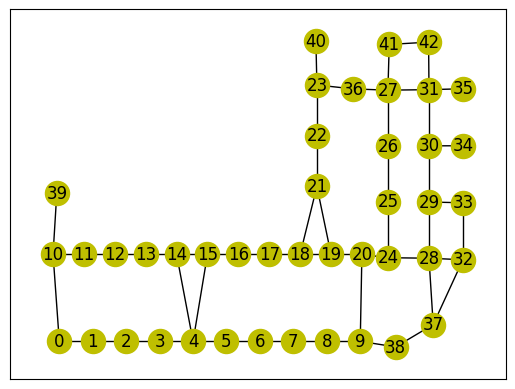

In [4]:
pos = nx.get_node_attributes(G, 'pos')
nx.draw_networkx(G, pos=pos, node_color='y')

In [5]:
# Create a path generator which feeds our model with customer paths
entrance_nodes = [39, 40, 41]
till_nodes = [33, 34, 35]
exit_nodes = [42]
item_nodes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
              19, 20, 21, 22, 23,24, 25, 26, 27, 28, 29, 30, 31, 32, 36, 37, 38]
mu = 0.07
sigma = 0.76
shortest_path_dict = get_all_shortest_path_dicts(G)
synthetic_path_generator_args = [mu, sigma, entrance_nodes, till_nodes, exit_nodes, item_nodes, shortest_path_dict]
path_generator_function, path_generator_args = get_path_generator(path_generation='synthetic',
                                                           synthetic_path_generator_args=synthetic_path_generator_args)

In [6]:
# Set parameters
config = {'arrival_rate': 2.55,  # Poisson rate at which customers arrive
           'traversal_time': 0.2,  # mean wait time per node
           'num_hours_open': 14,  # store opening hours
           'infection_proportion': 0.0011,  # proportion of customers that are infectious
         }

# Simulate several days and store results in results
num_days = 50
results = simulate_several_days(config, G, path_generator_function, path_generator_args, num_iterations=num_days)

100%|██████████| 50/50 [00:12<00:00,  3.87it/s]


The first element is a dataframe with most of the simulation metrics - one row for each simulation.

In [14]:
# results[0]

The second element gives the number of contacts between infectious customers and susceptible customers at each node (column) for each simulation (row).

In [12]:
# results[1]

The third element gives the total exposure time at each node (column) for each simulation (row).

In [13]:
# results[2]

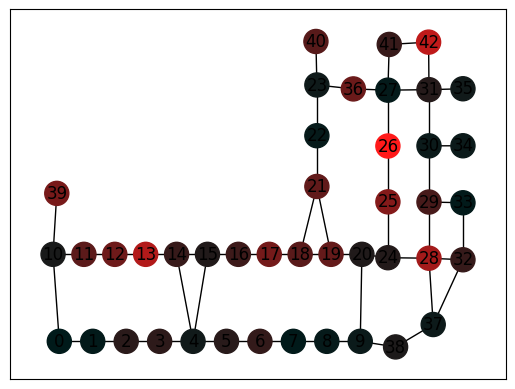

In [19]:
exposures = results[2].mean(0)
nx.draw_networkx(G, pos=pos, node_color=[((exposure-min(exposures))/(max(exposures)-min(exposures)), 0.1, 0.1) for exposure in exposures])


## Covid Exposure Interventions

### Restricting Maximum Number of Customers in Store

Limit store capacity to 10 customers

In [10]:
# Set parameters
config = {'arrival_rate': 2.55,  # Poisson rate at which customers arrive
           'traversal_time': 0.2,  # mean wait time per node
           'num_hours_open': 14,  # store opening hours
           'infection_proportion': 0.0011,  # proportion of customers that are infectious
           'max_customers_in_store_per_sqm': 0.24,  # Maximum number of customers per sqm (per zone) 
           'floorarea': 43  # Floor area (1 sqm per zone)
          #  'max_customers_in_store' = max_customers_in_store_per_sqm * floorarea
         }

# Simulate several days and store results in results
num_days = 50
results = simulate_several_days(config, G, path_generator_function, path_generator_args, num_iterations=num_days)

100%|██████████| 50/50 [00:09<00:00,  5.30it/s]


In [21]:
import numpy as np
rate_results = []

config = {'arrival_rate': 2.55,  # Poisson rate at which customers arrive
           'traversal_time': 0.2,  # mean wait time per node
           'num_hours_open': 14,  # store opening hours
           'infection_proportion': 0.0011,  # proportion of customers that are infectious
           'max_customers_in_store_per_sqm': 0.24,  # Maximum number of customers per sqm (per zone) 
           'floorarea': 43  # Floor area (1 sqm per zone)
          #  'max_customers_in_store' = max_customers_in_store_per_sqm * floorarea
         }


rates = np.linspace(0.05, 1, 10)
for rate in rates:
    config['max_customers_in_store_per_sqm'] = rate
    results = simulate_several_days(config, G, path_generator_function, path_generator_args, num_iterations=30,
                                    use_parallel=False)
    rate_results.append(results[0]['total_exposure_time'].mean())

100%|██████████| 30/30 [00:07<00:00,  4.05it/s]


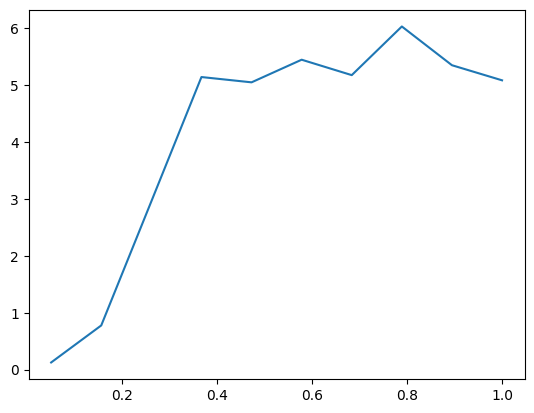

In [22]:
import matplotlib.pyplot as plt 

fig, ax = plt.subplots()
ax.plot(rates, rate_results)